## Find Homorhythm


#### This function predicts homorhythmic passages in a given piece.
    
The method follows various stages:
- gets **durational ngrams**, and finds passages in which these are the same in **more than two voices at a given offsets**
- gets **lyric ngrams**, and finds passages in which the **same sequence of two syllables** are heard successively in at least two voices at the **same offsets**.
- checks the **number of active voices** (so that we can count the number moving on coordinated homorhythm

to call the method:  

`homorhythm = piece.homorhythm2()`

##### View Score Excerpts with Verovio in the NB
It is also possible to display the results of the Homorhythm method in the Notebook with Verovio. The excerpts vary in length. Sometimes the same measure is part of overlapping groups--more work is pending to solve this problem.

The function also displays metadata about each excerpt: piece ID, composer, title, measures, and the minimum and maximum of voices in each passage moving in coordinated durations and syllables.

To use the function, pass the piece, homorhythm data frame, url of the piece, and mei_file name (all loaded in the first part of this notebook) as follows:

`verovio_print_homorhythm(piece, homorhythm, url, mei_file)`

In [1]:
import intervals
from intervals import * 
from intervals import main_objs
import intervals.visualizations as viz
import pandas as pd
import re
import altair as alt 
from ipywidgets import interact
from pandas.io.json import json_normalize
from pyvis.network import Network
from IPython.display import display
import requests
import os
import numpy
import itertools
import verovio
MYDIR = ("saved_csv")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")
    
MUSDIR = ("Music_Files")
CHECK_FOLDER = os.path.isdir(MUSDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MUSDIR)
    print("created folder : ", MUSDIR)

else:
    print(MUSDIR, "folder already exists.")

saved_csv folder already exists.
Music_Files folder already exists.


## Import Your Piece

- Here you will want to select the appropriate 'prefix' that identifies the location of your file.
- `'Music_Files/'` is for files in the local notebook; `'https://crimproject.org/mei/'` is for the files on CRIM.
- Then provide the full name (and extension) of your music file, such as `'CRIM_Model_0038.mei'`

In [17]:
# Select a prefix:

# prefix = 'Music_Files/'
prefix = 'https://crimproject.org/mei/'

# Add your filename here

mei_file = 'CRIM_Model_0002.mei'

url = prefix + mei_file

piece = importScore(url)

print(piece.metadata)

Successfully imported https://crimproject.org/mei/CRIM_Model_0002.mei
{'title': 'O gente brunette', 'composer': 'Thomas Champion'}


In [18]:
homorhythm = piece.homorhythm()


In [19]:
# July 2022 Addition for printing hr types with Verovio
def verovio_print_homorhythm2(piece, homorhythm, prefix, url, mei_file):

    '''
    This function is used to display the results of the homorhythm function
    in the Notebook with Verovio.  Each excerpt follows the full measure
    span of the homorhythm passage found by that function.
    The function also displays metadata about each excerpt, drawn from the
    homorhythm dataframe:  piece ID, composer, title, measure range,
    and the minimum and maximum number of homorhythmic voices in that passage.
    Usage:
    verovio_print_homorhythm(piece, homorhythm, url, mei_file)
    Note that the arguments here are the same ones used for the importing the
    original piece (which is needed for Verovio and metadata reporting).  The 'homorhythm'
    argument is simply the result of the homorhythm operation.
    '''



    if prefix == 'Music_Files/':
        text_file = open(url, "r")
        fetched_mei_string = text_file.read()
    else:
        response = requests.get(url)
        fetched_mei_string = response.text
    tk = verovio.toolkit()
    tk.loadData(fetched_mei_string)
    tk.setScale(30)
    tk.setOption( "pageHeight", "1000" )
    tk.setOption( "pageWidth", "2500" )

    # Now get meas ranges and number of active voices
    hr_list = list(homorhythm.index.get_level_values('Measure').tolist())
    #Get the groupings of consecutive items
    li = [list(item) for item in consecutive_groups(hr_list)]
    final_list = []
    new_final = []

    # Look ahead and combine overlaps
    for l in range(len(li)):
    # look ahead
        if l < len(li) - 1:
            overlap_check = any(item in li[l] for item in li[l+1])
            if overlap_check==False:
                sorted(li[l])
                final_list.append(li[l])
            if overlap_check==True:
                combined = sorted(list(set(li[l] + li[l+1])))
                final_list.append(combined)
    # Look back and combine overlaps
    for l in range(len(final_list)):
        new_final.append(final_list[0])
        if l > 0:
            overlap_check = any(item in final_list[l] for item in final_list[l-1])
            if overlap_check==False:
                new_final.append(final_list[l])
            if overlap_check==True:
                combined = sorted(list(set(final_list[l] + final_list[l-1])))
                new_final.append(combined)

    # ensure final list is only unique lists
    final_final = []
    for elem in new_final:
        if elem not in final_final:
            final_final.append(elem)
#     print(final_final)
    #Use the result to get range groupings
    for span in final_final:
        mr = str(span[0]) + "-" + str(span[-1])
        mdict = {'measureRange': mr}
        min_hr_count = int(homorhythm.loc[span]["active_syll_voices"].values.min())
        max_hr_count = int(homorhythm.loc[span]["active_syll_voices"].values.max())

        # select verovio measures and redo layout
        tk.select(str(mdict))
        tk.redoLayout()

        # get the number of pages and display the music
        print("Results:")
        count = tk.getPageCount()
        print("MEI File: ", mei_file)
        print(piece.metadata['composer'])
        print(piece.metadata['title'])
        print("HR Start Measure: ", span[0])
        print("HR Stop Measure: ", span[-1])
        print("Minimum Number of HR Voices: ", min_hr_count)
        print("Maximum Number of HR Voices: ", max_hr_count)

        for c in range(1, count + 1):
            music = tk.renderToSVG(c)

            # display(SVG(music))
            display(HTML(music))

In [20]:
verovio_print_homorhythm2(piece, homorhythm, prefix, url, mei_file)

Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  1
HR Stop Measure:  1
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  1
HR Stop Measure:  2
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  4
HR Stop Measure:  6
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  6
HR Stop Measure:  6
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  6
HR Stop Measure:  7
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  6
HR Stop Measure:  9
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  11
HR Stop Measure:  12
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  11
HR Stop Measure:  13
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  12
HR Stop Measure:  14
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  13
HR Stop Measure:  15
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  14
HR Stop Measure:  15
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  14
HR Stop Measure:  17
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  15
HR Stop Measure:  18
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  17
HR Stop Measure:  19
Minimum Number of HR Voices:  3
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  18
HR Stop Measure:  19
Minimum Number of HR Voices:  3
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  18
HR Stop Measure:  20
Minimum Number of HR Voices:  3
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  19
HR Stop Measure:  20
Minimum Number of HR Voices:  3
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  20
HR Stop Measure:  21
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  21
HR Stop Measure:  21
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  23
HR Stop Measure:  23
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  23
HR Stop Measure:  24
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  24
HR Stop Measure:  24
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  24
HR Stop Measure:  25
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  27
HR Stop Measure:  29
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  29
HR Stop Measure:  29
Minimum Number of HR Voices:  4
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  29
HR Stop Measure:  30
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


Results:
MEI File:  CRIM_Model_0002.mei
Thomas Champion
O gente brunette
HR Start Measure:  29
HR Stop Measure:  32
Minimum Number of HR Voices:  2
Maximum Number of HR Voices:  4


In [11]:

# active version with lyric ngs
nr = piece.notes()
dur = piece.durations(df=nr)
ng = piece.ngrams(df=dur, n=2)
dur_ngrams = []
for index, rows in ng.iterrows():
    dur_ngrams_no_nan = [x for x in rows if pd.isnull(x) == False]
    dur_ngrams.append(dur_ngrams_no_nan)

ng['dur_ngrams'] = dur_ngrams

ng['active_voices'] = ng['dur_ngrams'].apply(len)
ng['number_dur_ngrams'] = ng['dur_ngrams'].apply(set).apply(len)
ng = ng[(ng['number_dur_ngrams'] < 2) & (ng['active_voices'] > 1)]
nr.ffill(inplace=True)
# index_of_rests = []
# rests = []
# for index, rows in nr.iterrows():
#     rest_test = [y for y in rows if y == "Rest"]
#     rests.append(rest_test)
# nr["rests"] = rests  
# nr["rests_count"] = nr["rests"].apply(len)
# full_stop = nr[(nr['rests_count'] > 1) ]
# rests_with_mb = piece.detailIndex(full_stop)

# get the lyrics as ngrams to match the durations
lyrics = piece.lyrics()
lyrics = lyrics.applymap(alpha_only)
lyrics_ng = piece.ngrams(df=lyrics, n=2)

# count the lyric_ngrams at each position 
syll_set = []
for index, rows in lyrics_ng.iterrows():
    syll_no_nan = [z for z in rows if pd.isnull(z) == False]
    syll_set.append(syll_no_nan)
lyrics_ng['syllable_set'] = syll_set
lyrics_ng["count_lyr_ngrams"] = lyrics_ng["syllable_set"].apply(set).apply(len)

# and the number of active voices
lyrics_ng['active_syll_voices'] = lyrics_ng['syllable_set'].apply(len)

# finally predict the hr moments, based on the number of both active voices (> 1) and count of lyric ngrams (1)
# lyrics_hr = lyrics_ng[(lyrics_ng['active_syll_voices'] > 1) & (lyrics_ng['count_lyr_ngrams'] < 2)]
hr_sylls_mask = lyrics_ng[(lyrics_ng['active_syll_voices'] > 1) & (lyrics_ng['count_lyr_ngrams'] < 2)]

# measures and beats, plus a mask
# piece.detailIndex(lyrics_hr, offset=True)
# hr_sylls_mask = lyrics_hr["active_syll_voices"]

# combine of both dur_ng and lyric_ng to show passages where more than 2 voices have the same syllables and durations
ng = ng[['active_voices', "number_dur_ngrams"]]
hr = pd.merge(ng, hr_sylls_mask, left_index=True, right_index=True)
# the intersection of coordinated durations and coordinate lyrics
hr['voice_match'] = hr['active_voices'] == hr['active_syll_voices']
result = piece.di(hr)
result

NameError: name 'alpha_only' is not defined

In [76]:
lyrics_ng

,Discantus,Altus,Tenor,Bassus,syllable_set,count_lyr_ngrams,active_syll_voices
0.0,"(Si, bo)",NaN,NaN,NaN,"[(Si, bo)]",1,1
4.0,NaN,"(Si, bo)",NaN,NaN,"[(Si, bo)]",1,1
8.0,"(bo, na)",NaN,NaN,NaN,"[(bo, na)]",1,1
12.0,"(na, su)","(bo, na)",NaN,NaN,"[(na, su), (bo, na)]",2,2
16.0,"(su, sce)","(na, su)",NaN,NaN,"[(su, sce), (na, su)]",2,2
20.0,NaN,"(su, sce)",NaN,NaN,"[(su, sce)]",1,1
26.0,"(sce, pi)",NaN,NaN,NaN,"[(sce, pi)]",1,1
28.0,"(pi, mus)",NaN,NaN,NaN,"[(pi, mus)]",1,1
30.0,NaN,"(sce, pi)",NaN,NaN,"[(sce, pi)]",1,1
32.0,"(mus, de)","(pi, mus)","(Si, bo)",NaN,"[(mus, de), (pi, mus), (Si, bo)]",3,3


In [75]:
pd.set_option('display.max_rows', None)


In [55]:
# do not use!

nr = piece.notes()
dur = piece.durations(df=nr)
ng = piece.ngrams(df=dur, n=2)
dur_ngrams = []
for index, rows in ng.iterrows():
    dur_ngrams_no_nan = [x for x in rows if pd.isnull(x) == False]
    dur_ngrams.append(dur_ngrams_no_nan)

ng['dur_ngrams'] = dur_ngrams

ng['active_voices'] = ng['dur_ngrams'].apply(len)
ng['number_dur_ngrams'] = ng['dur_ngrams'].apply(set).apply(len)
ng = ng[(ng['number_dur_ngrams'] < 2) & (ng['active_voices'] > 1)]
nr.ffill(inplace=True)
# get the lyrics as ngrams to match the durations
lyrics = piece.lyrics()
lyrics = lyrics.applymap(alpha_only)
lyrics_ng = piece.ngrams(df=lyrics, n=2)

# count the lyric_ngrams at each position 
syll_set = []
for index, rows in lyrics_ng.iterrows():
    syll_no_nan = [z for z in rows if pd.isnull(z) == False]
    syll_set.append(syll_no_nan)
lyrics_ng['syllable_set'] = syll_set
lyrics_ng["count_lyr_ngrams"] = lyrics_ng["syllable_set"].apply(set).apply(len)

# and the number of active voices
lyrics_ng['active_syll_voices'] = lyrics_ng['syllable_set'].apply(len)

# finally predict the hr moments, based on the number of both active voices (> 1) and count of lyric ngrams (1)
lyrics_hr = lyrics_ng[(lyrics_ng['active_syll_voices'] > 1) & (lyrics_ng['count_lyr_ngrams'] < 2)]

# measures and beats, plus a mask
# piece.detailIndex(lyrics_hr, offset=True)
hr_sylls_mask = lyrics_hr["active_syll_voices"]

# combine of both dur_ng and lyric_ng to show passages where more than 2 voices have the same syllables and durations
ng = ng[['active_voices', "number_dur_ngrams"]]
hr = pd.merge(ng, hr_sylls_mask, left_index=True, right_index=True)
# the intersection of coordinated durations and coordinate lyrics
hr['voice_match'] = hr['active_voices'] == hr['active_syll_voices']
# result = piece.di(hr, beat=False)
# result

### Find Homorhythm

* The function is extremely simple, and requires no parameters:
* `piece.homorhythm()`
* The resulting data frame show the measures/beats, and offsets
* The method follows various stages:

- gets durational ngrams, and finds passages in which these are the same in more than two voices at a given offsets, thus `number_dur_grams = 1` in the results
- gets syllables at every offset, and identifies passages where more than two voices are singing the same lyrics, thus `active_syll_voices` in the results
- checks the number of active voices (thus eliminating places where some voices have rests), thus `active_voices` in the results

* Read the documentation:  `print(piece.homorhythm.__doc__)`





In [6]:
# Fills in gaps of HR measures  WORKS!

from more_itertools import consecutive_groups
# Now get meas ranges and number of active voices
hr = list(result.index.get_level_values('Measure').tolist())
#Get the groupings of consecutive items
li = [list(item) for item in consecutive_groups(hr)]
print("original list:", li)
final_list = []
new_final = []


# Look ahead and combine overlaps
for l in range(len(li)):   
    # look ahead
    if l < len(li) - 1:
        overlap_check = any(item in li[l] for item in li[l+1])
        if overlap_check==False:
            sorted(li[l])
            final_list.append(li[l])
        if overlap_check==True:      
            combined = sorted(list(set(li[l] + li[l+1])))
            final_list.append(combined)
# Look back and combine overlaps
for l in range(len(final_list)):
    if l > 0:
        overlap_check = any(item in final_list[l] for item in final_list[l-1])
        if overlap_check==False:
            new_final.append(final_list[l])
        if overlap_check==True:
            combined = sorted(list(set(final_list[l] + final_list[l-1])))
            new_final.append(combined)

# ensure final list is only unique lists
final_final = []
for elem in new_final:
    if elem not in final_final:
        final_final.append(elem)

print("This is the Final Final!: ", final_final)
    


original list: [[12], [26], [34], [37, 38], [38, 39], [39], [39, 40], [44], [44, 45], [48, 49, 50, 51], [51], [51, 52, 53], [56]]
This is the Final Final!:  [[26], [34], [37, 38, 39], [38, 39, 40], [39, 40], [44, 45], [48, 49, 50, 51], [48, 49, 50, 51, 52, 53], [51, 52, 53]]


In [50]:
result["active_syll_voices"].values.max()

4.0

In [7]:
response = requests.get(url)
fetched_mei_string = response.text
tk = verovio.toolkit()
tk.loadData(fetched_mei_string)
tk.setScale(30)
tk.setOption( "pageHeight", "1000" )
tk.setOption( "pageWidth", "2500" )

# Now get meas ranges and number of active voices
hr = list(result.index.get_level_values('Measure').tolist())
#Get the groupings of consecutive items
li = [list(item) for item in consecutive_groups(hr)]
final_list = []
new_final = []

# Look ahead and combine overlaps
for l in range(len(li)):   
    # look ahead
    if l < len(li) - 1:
        overlap_check = any(item in li[l] for item in li[l+1])
        if overlap_check==False:
            sorted(li[l])
            final_list.append(li[l])
        if overlap_check==True:      
            combined = sorted(list(set(li[l] + li[l+1])))
            final_list.append(combined)
# Look back and combine overlaps
for l in range(len(final_list)):
    new_final.append(final_list[0])
    if l > 0:
        overlap_check = any(item in final_list[l] for item in final_list[l-1])
        if overlap_check==False:
            new_final.append(final_list[l])
        if overlap_check==True:
            combined = sorted(list(set(final_list[l] + final_list[l-1])))
            new_final.append(combined)

# ensure final list is only unique lists
final_final = []
for elem in new_final:
    if elem not in final_final:
        final_final.append(elem)

#Use the result to get range groupings
for span in final_final:
    mr = str(span[0]) + "-" + str(span[-1])
    mdict = {'measureRange': mr}
    min_hr_count = int(result.loc[span]["active_syll_voices"].values.min())
    max_hr_count = int(result.loc[span]["active_syll_voices"].values.max())

    # select verovio measures and redo layout
    tk.select(str(mdict))
    tk.redoLayout()

    # get the number of pages and display the music
    print("Results:")
    count = tk.getPageCount()
    print("MEI File: ", mei_file)
    print(piece.metadata['composer'])
    print(piece.metadata['title'])
    print("HR Start Measure: ", span[0])
    print("HR Stop Measure: ", span[-1])
    print("Minimum Number of HR Voices: ", min_hr_count)
    print("Maximum Number of HR Voices: ", max_hr_count)
    
    for c in range(1, count + 1):
        music = tk.renderToSVG(c)
        
        display(SVG(music))

[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'


original list: [[12], [26], [34], [37, 38], [38, 39], [39], [39, 40], [44], [44, 45], [48, 49, 50, 51], [51], [51, 52, 53], [56]]
This is the Final Final!:  [[12], [26], [34], [37, 38, 39], [38, 39, 40], [39, 40], [44, 45], [48, 49, 50, 51], [48, 49, 50, 51, 52, 53], [51, 52, 53]]
Results:
MEI File:  CRIM_Model_0020.mei
Roland de Lassus
Susanne un jour
HR Start Measure:  12
HR Stop Measure:  12
Minimum Number of HR Voices:  3
Maximum Number of HR Voices:  3


NameError: name 'SVG' is not defined

In [66]:
span = [33, 34, 35, 36]
indices  = [index for (index, item) in enumerate(span)]

indices

[0, 1, 2, 3]

In [17]:
hr_full = hr[hr['voice_match'] == True]

hr_staggered = hr[hr['voice_match'] == False]
hr_full
hr_full

active_voices  number_dur_ngrams  active_syll_voices  \
Measure Beat Offset                                                         
1       1.0  0.0               6.0                1.0                 6.0   
        2.0  2.0               6.0                1.0                 6.0   
        2.5  3.0               6.0                1.0                 6.0   
        3.0  4.0               6.0                1.0                 6.0   
        4.0  6.0               6.0                1.0                 6.0   
...                            ...                ...                 ...   
58      1.0  456.0             6.0                1.0                 6.0   
59      1.0  464.0             6.0                1.0                 6.0   
        4.0  470.0             6.0                1.0                 6.0   
        4.5  471.0             6.0                1.0                 6.0   
60      1.0  472.0             6.0                1.0                 6.0   

                     voice_match  
Measure Beat Offset               
1       1.0  0.0            True  
        2.0  2.0            True  
        2.5  3.0            True  
        3.0  4.0            True  
        4.0  6.0            True  
...                          ...  
58      1.0  456.0          True  
59      1.0  464.0          True  
        4.0  470.0          True  
        4.5  471.0          True  
60      1.0  472.0          True  

[201 rows x 4 columns]

In [ ]:
span = "1-4"


In [11]:
hr_list = hr_staggered.index.get_level_values(2).to_list()
hr_list

[110.0]

In [16]:
hr_list = hr_full.index.get_level_values(2).to_list()
ng = piece.ngrams()
hr_ng = ng.filter(hr_list, axis=0)
hr_ng


,Bassus_Quinta,Bassus_Tenor,Bassus_Altus,Bassus_Sexta,Bassus_Cantus,Quinta_Tenor,Quinta_Altus,Quinta_Sexta,Quinta_Cantus,Tenor_Altus,Tenor_Sexta,Tenor_Cantus,Altus_Sexta,Altus_Cantus,Sexta_Cantus
0.0,"3_-4, 5_1, 5","5_-4, 8_1, 8","8_-4, 10_1, 10","8_-4, 12_1, 12","12_-4, 15_1, 15","3_-2, 4_1, 4","6_-2, 6_1, 6","6_-2, 8_1, 8","10_-2, 11_1, 11","4_1, 3_1, 3","4_1, 5_1, 5","8_1, 8_1, 8","1_-2, 3_1, 3","5_-2, 6_1, 6","5_2, 4_1, 4"
2.0,"5_1, 5_-5, 8","8_1, 8_-5, 12","10_1, 10_-5, 15","12_1, 12_-5, 19","15_1, 15_-5, 17","4_1, 4_-2, 5","6_1, 6_-2, 8","8_1, 8_-2, 12","11_1, 11_-2, 10","3_1, 3_1, 4","5_1, 5_1, 8","8_1, 8_1, 6","3_1, 3_2, 5","6_1, 6_2, 3","4_1, 4_4, -3"
3.0,"5_-5, 8_4, 5","8_-5, 12_4, 8","10_-5, 15_4, 10","12_-5, 19_4, 12","15_-5, 17_4, 15","4_-2, 5_1, 4","6_-2, 8_1, 6","8_-2, 12_1, 8","11_-2, 10_1, 11","3_1, 4_-2, 3","5_1, 8_-2, 5","8_1, 6_-2, 8","3_2, 5_-3, 3","6_2, 3_-3, 6","4_4, -3_-5, 4"
4.0,"8_4, 5_1, 5","12_4, 8_1, 8","15_4, 10_1, 10","19_4, 12_1, 12","17_4, 15_1, 15","5_1, 4_1, 4","8_1, 6_1, 6","12_1, 8_1, 8","10_1, 11_1, 11","4_-2, 3_1, 3","8_-2, 5_1, 5","6_-2, 8_1, 8","5_-3, 3_1, 3","3_-3, 6_1, 6","-3_-5, 4_1, 4"
6.0,"5_1, 5_-5, 8","8_1, 8_-5, 12","10_1, 10_-5, 15","12_1, 12_-5, 17","15_1, 15_-5, 19","4_1, 4_-2, 5","6_1, 6_-2, 8","8_1, 8_-2, 10","11_1, 11_-2, 12","3_1, 3_1, 4","5_1, 5_1, 6","8_1, 8_1, 8","3_1, 3_2, 3","6_1, 6_2, 5","4_1, 4_2, 3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456.0,"5_-4, 8_5, 5","8_-4, 12_5, 8","10_-4, 15_5, 11","12_-4, 19_5, 15","15_-4, 17_5, 12","4_1, 5_2, 4","6_1, 8_2, 7","8_1, 12_2, 11","11_1, 10_2, 8","3_2, 4_1, 4","5_2, 8_1, 8","8_2, 6_1, 5","3_3, 5_1, 5","6_3, 3_1, 2","4_5, -3_1, -4"
464.0,"8_5, 5_-5, 8","12_5, 8_-5, 12","15_5, 10_-5, 15","17_5, 15_-5, 19","19_5, 12_-5, 17","5_2, 4_-2, 5","8_2, 6_-2, 8","10_2, 11_-2, 12","12_2, 8_-2, 10","4_1, 3_1, 4","6_1, 8_1, 8","8_1, 5_1, 6","3_-2, 6_2, 5","5_-2, 3_2, 3","3_3, -4_1, -3"
470.0,"8_1, 8_4, 5","12_1, 12_4, 8","15_1, 15_4, 10","19_1, 19_4, 12","17_1, 17_4, 15","5_1, 5_1, 4","8_1, 8_1, 6","12_1, 12_1, 8","10_1, 10_1, 11","4_1, 4_-2, 3","8_1, 8_-2, 5","6_1, 6_-2, 8","5_1, 5_-3, 3","3_1, 3_-3, 6","-3_1, -3_-5, 4"
471.0,"8_4, 5_-4, 8","12_4, 8_-4, 12","15_4, 10_-4, 15","19_4, 12_-4, 19","17_4, 15_-4, 17","5_1, 4_1, 5","8_1, 6_1, 8","12_1, 8_1, 12","10_1, 11_1, 10","4_-2, 3_2, 4","8_-2, 5_2, 8","6_-2, 8_2, 6","5_-3, 3_3, 5","3_-3, 6_3, 3","-3_-5, 4_5, -3"


In [32]:
ngrams = piece.ngrams()
ngrams
filtered_ngrams = ngrams[ngrams.apply(lambda x: x.astype(str).str.contains('8_1, 8_1, 8').any(), axis=1)]#.copy()
filtered_ngrams

,Bassus_Secundus Tenor,Bassus_Primus Tenor,Bassus_Contratenor,Bassus_Superius,Secundus Tenor_Primus Tenor,Secundus Tenor_Contratenor,Secundus Tenor_Superius,Primus Tenor_Contratenor,Primus Tenor_Superius,Contratenor_Superius
330.0,"5_-2, 6_2, 5",NaN,"10_-2, 10_2, 8","12_-2, 13_2, 12",NaN,"6_1, 5_1, 4","8_1, 8_1, 8",NaN,NaN,"3_-2, 4_-2, 5"
690.0,"8_1, 8_1, 8","5_1, 5_1, 5","10_1, 10_1, 10","12_1, 12_1, 12","-4_1, -4_1, -4","3_1, 3_1, 3","5_1, 5_1, 5","6_1, 6_1, 6","8_1, 8_1, 8","3_1, 3_1, 3"
694.0,"8_1, 8_1, 8","5_1, 5_1, 5","10_1, 10_1, 10","12_1, 12_1, 12","-4_1, -4_1, -4","3_1, 3_1, 3","5_1, 5_1, 5","6_1, 6_1, 6","8_1, 8_1, 8","3_1, 3_1, 3"
1548.0,"5_1, 5_1, 3","8_1, 8_1, 8","10_1, 10_1, 10","12_1, 12_1, 15","4_1, 4_-3, 6","6_1, 6_-3, 8","8_1, 8_-3, 13","3_1, 3_Held, 3","5_1, 5_Held, 8","3_1, 3_1, 6"
2116.0,NaN,"8_1, 8_Held, 8",NaN,"15_1, 15_1, 15",NaN,NaN,NaN,NaN,"8_1, 8_1, 8",NaN


### Here We Explain the Steps

In [5]:
# function for removing non alpha characters from texts

def alpha_only(value):
    if isinstance(value, str):
        return re.sub(r'[^a-zA-Z]', '', value)
    else:
        return value

In [21]:
def find_hr(piece):
    nr = piece.notes()
    dur = piece.durations(df=nr)
    ng = piece.ngrams(df=dur, n=2)
    dur_ngrams = []
    
    # find passages with more than 2 active voices
    for index, rows in ng.iterrows():

        dur_ngrams_no_nan = [x for x in rows if pd.isnull(x) == False]
        dur_ngrams.append(dur_ngrams_no_nan)

    ng['dur_ngrams'] = dur_ngrams
    ng['active_voices'] = ng['dur_ngrams'].apply(len)
    ng['number_dur_ngrams'] = ng['dur_ngrams'].apply(set).apply(len)
    ng = ng[(ng['number_dur_ngrams'] < 2) & (ng['active_voices'] > 1)]
    
    # check rests in multiple parts
    nr.ffill(inplace=True)
    index_of_rests = []
    rests = []
    for index, rows in nr.iterrows():
        rest_test = [y for y in rows if y == "Rest"]
        rests.append(rest_test)
    
    # index_of_rests.append(index)
    nr["rests"] = rests  
    nr["rests_count"] = nr["rests"].apply(len)
    full_stop = nr[(nr['rests_count'] > 1) ]
    rests_with_mb = piece.detailIndex(full_stop)
    # now get lyric syllables
    lyrics = piece.getLyric()
    lyrics = lyrics.applymap(alpha_only)
    cols = lyrics.columns
    for col in cols:
        lyrics[col] = lyrics[col].str.lower()
    syll_set = []
    for index2, rows2 in lyrics.iterrows():
        syll_no_nan = [z for z in rows2 if pd.isnull(z) == False]
        syll_set.append(syll_no_nan)
    #     print(syll_no_nan)
    lyrics['syllable_set'] = syll_set
    
    # create mask consisting of passages with more than two voices actively singing same syllables
    lyrics['active_syll_voices'] = lyrics['syllable_set'].apply(len)
    # count how _many_ syllables at this offset
    lyrics['number_sylls'] = lyrics['syllable_set'].apply(set).apply(len)
    # get count of possible hr passages (several voices with same syllable)
    lyrics_hr = lyrics[(lyrics['active_syll_voices'] > 1) & (lyrics['number_sylls'] < 2)]
    # piece.detailIndex(lyrics_hr, offset=True)
    # lyrics['is_hr'] = np.where(lyrics['active_voices'] > 3) 
    hr_sylls_mask = lyrics_hr["active_syll_voices"]
    
    # combine results to show passages where more than 2 voices have the same syllables and durations
    ng = ng[['active_voices', "number_dur_ngrams"]]
    hr = pd.merge(ng, hr_sylls_mask, left_index=True, right_index=True)
    result = piece.detailIndex(hr, offset=True)
    return ng

In [22]:
hr = find_hr(piece)
result = piece.detailIndex(hr, offset=True)
result

active_voices  number_dur_ngrams
Measure Beat Offset                                  
24      1.0  184.0             2.0                1.0
27      1.0  208.0             2.0                1.0
28      4.0  222.0             2.0                1.0
31      3.0  244.0             2.0                1.0
32      3.0  252.0             2.0                1.0
33      1.0  256.0             2.0                1.0
35      3.0  276.0             2.0                1.0
38      1.5  297.0             2.0                1.0
        4.0  302.0             2.0                1.0
39      1.0  304.0             3.0                1.0
40      1.0  312.0             3.0                1.0
        3.0  316.0             4.0                1.0
41      1.0  320.0             4.0                1.0
50      2.0  394.0             2.0                1.0
        2.5  395.0             2.0                1.0
        3.5  397.0             2.0                1.0
51      2.5  403.0             2.0                1.0
        3.5  405.0             2.0                1.0
52      1.0  408.0             3.0                1.0
54      1.0  424.0             2.0                1.0
71      1.0  560.0             2.0                1.0
72      3.0  572.0             3.0                1.0
76      3.0  604.0             2.0                1.0
78      3.0  620.0             2.0                1.0
        4.0  622.0             2.0                1.0
79      1.0  624.0             2.0                1.0
81      3.0  644.0             2.0                1.0
        4.0  646.0             2.0                1.0
84      3.0  668.0             2.0                1.0
        4.0  670.0             2.0                1.0
93      1.0  736.0             2.0                1.0
94      1.0  748.0             4.0                1.0
        2.0  752.0             4.0                1.0
96      3.0  780.0             3.0                1.0
97      3.0  792.0             3.0                1.0
98      1.0  796.0             4.0                1.0
        2.0  800.0             4.0                1.0
100     3.0  828.0             3.0                1.0
101     3.0  840.0             3.0                1.0
102     3.0  852.0             3.0                1.0
107     3.0  912.0             3.0                1.0
112     1.0  952.0             2.0                1.0
115     1.0  976.0             3.0                1.0
123     1.0  1040.0            3.0                1.0
127     1.0  1072.0            2.0                1.0
139     2.0  1170.0            2.0                1.0
        4.0  1174.0            2.0                1.0
141     1.0  1184.0            3.0                1.0
142     1.0  1192.0            3.0                1.0
143     1.0  1200.0            4.0                1.0
144     1.0  1208.0            4.0                1.0
146     1.0  1224.0            4.0                1.0
147     1.0  1232.0            4.0                1.0
        3.0  1236.0            4.0                1.0
148     1.0  1240.0            4.0                1.0
150     1.0  1256.0            4.0                1.0
151     1.0  1272.0            4.0                1.0

In [162]:
hr = find_hr(piece)
hr.head(3)

hr['voice_match'] = hr['active_voices'] == hr['active_syll_voices']
hr = hr.groupby('Measure').first()
ind_list = hr.index.to_list()
for i in range(len(ind_list)-1):
    if ind_list[i+1] - ind_list[i] == 2:
        new_index = ind_list[i] + 1
        hr.loc[new_index] = 'NaN', 'NaN', 'NaN', 'NaN'
#         print(out2.loc[new_index])
hr = hr.sort_index()
hr

,active_voices,number_dur_ngrams,active_syll_voices,voice_match
Measure,,,,
31,2.0,1.0,2.0,True
32,2.0,1.0,2.0,True
33,2.0,1.0,2.0,True
34,NaN,NaN,NaN,NaN
35,2.0,1.0,2.0,True
38,2.0,1.0,2.0,True
39,3.0,1.0,3.0,True
40,4.0,1.0,4.0,True
41,4.0,1.0,4.0,True


Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  31
HR Stop Measure:  35
Active Voices:  2.0
Type:  Full Homorhythm


[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>
[Warning] 4 time pointing element(s) could not be matched in measure m-4149
[Warning] 4 time pointing element(s) could not be matched in measure m-4132
[Warning] 4 time pointing element(s) could not be matched in measure m-4098


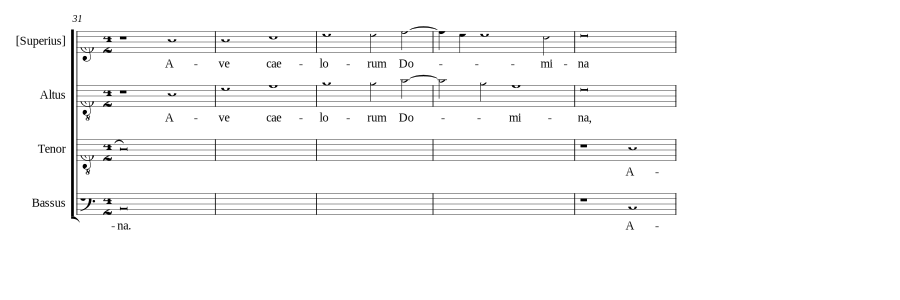

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  38
HR Stop Measure:  41
Active Voices:  2.0
Type:  Full Homorhythm


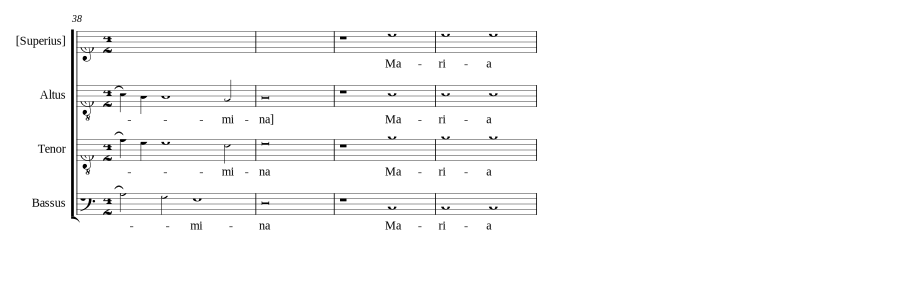

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  52
HR Stop Measure:  52
Active Voices:  2.0
Type:  Staggered Homorhythm


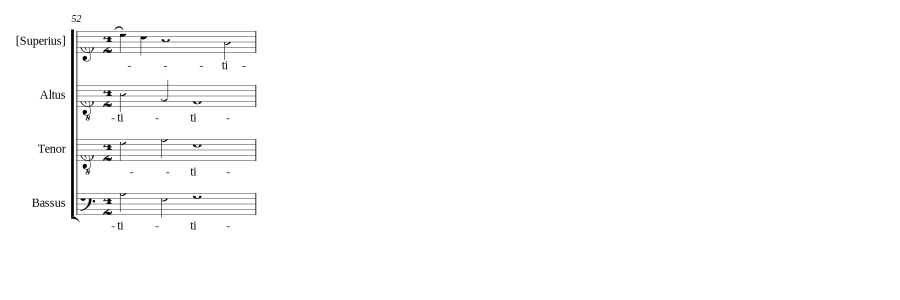

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  76
HR Stop Measure:  81
Active Voices:  2.0
Type:  Full Homorhythm


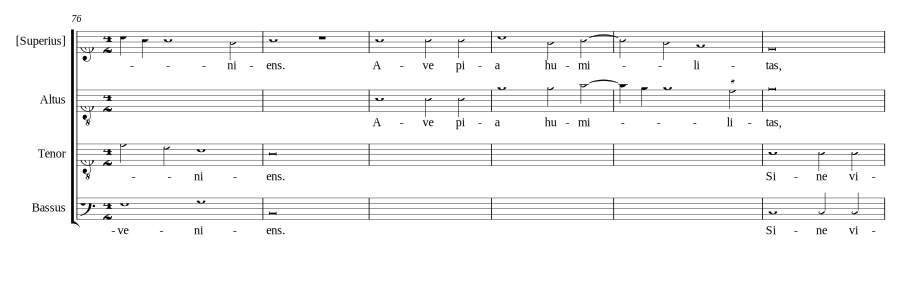

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  93
HR Stop Measure:  102
Active Voices:  2.0
Type:  Full Homorhythm


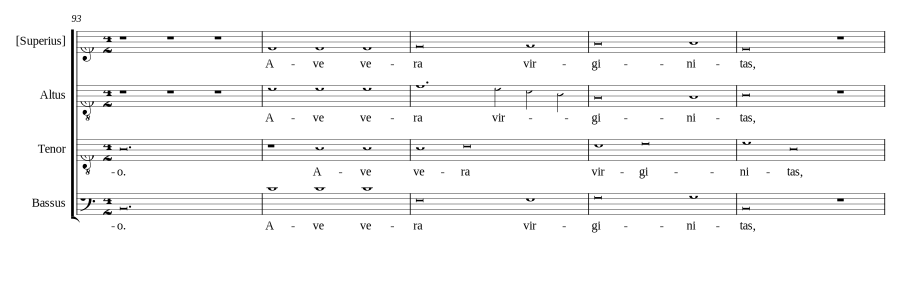

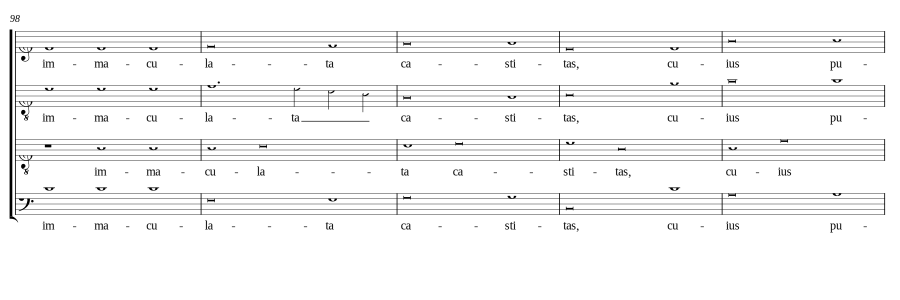

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  112
HR Stop Measure:  112
Active Voices:  2.0
Type:  Full Homorhythm


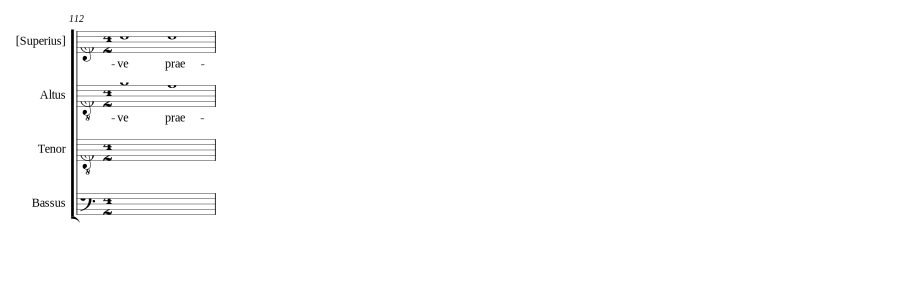

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  115
HR Stop Measure:  115
Active Voices:  2.0
Type:  Staggered Homorhythm


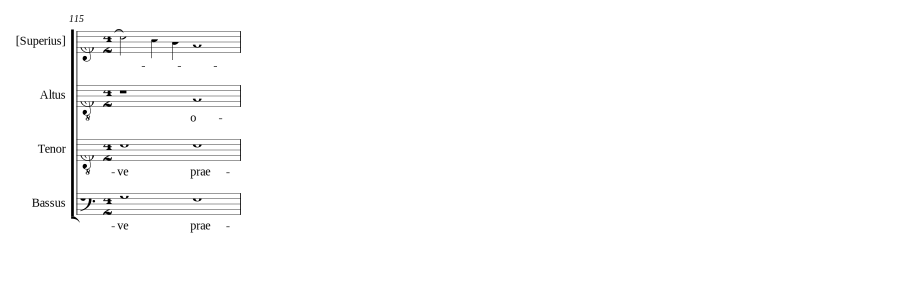

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  123
HR Stop Measure:  123
Active Voices:  2.0
Type:  Staggered Homorhythm


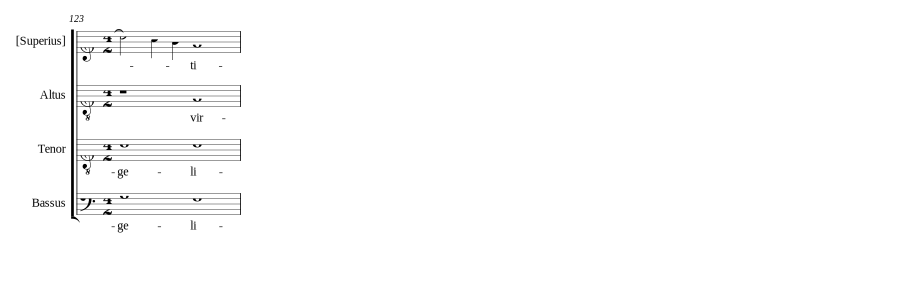

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  127
HR Stop Measure:  127
Active Voices:  2.0
Type:  Full Homorhythm


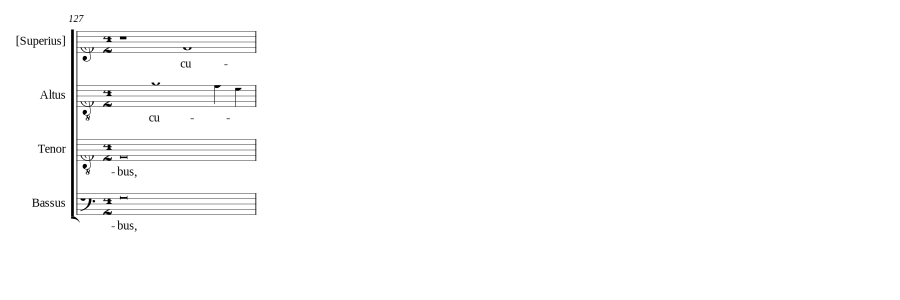

Results:
MEI File:  CRIM_Model_0008.mei
Josquin Des Prés
Ave Maria
HR Start Measure:  141
HR Stop Measure:  151
Active Voices:  3.0
Type:  Full Homorhythm


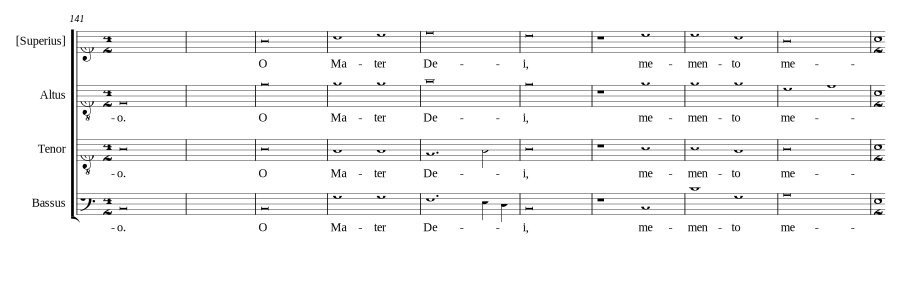

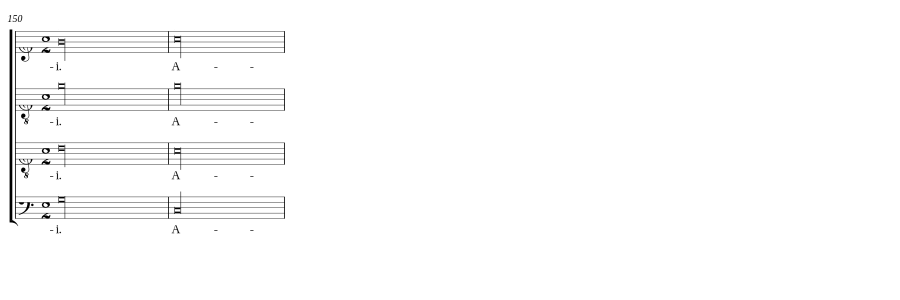

In [161]:
response = requests.get(url)
fetched_mei_string = response.text
tk = verovio.toolkit()
tk.loadData(fetched_mei_string)
tk.setScale(30)
tk.setOption( "pageHeight", "1000" )
tk.setOption( "pageWidth", "3000" )

# Now get meas ranges and number of active voices
mg = list(hr.index.get_level_values('Measure').tolist())
#Get the groupings of consecutive items
li = [list(item) for item in consecutive_groups(mg)]

#Use the result to get range groupings
meas_spans = [ [item[0],item[-1]] if len(item) > 1 else [item[0]] for item in li]
for span in meas_spans:
    mr = str(span[0]) + "-" + str(span[-1])
    mdict = {'measureRange': mr}
    count_hr_voices = hr.loc[span[0]]["active_syll_voices"]
    if hr.loc[span[0]]["voice_match"] == True:
        hr_type = "Full Homorhythm"
    else:
        hr_type = "Staggered Homorhythm"

    # select verovio measures and redo layout
    tk.select(str(mdict))
    tk.redoLayout()

    # get the number of pages and display the music
    print("Results:")
    count = tk.getPageCount()
    print("MEI File: ", mei_file)
    print(piece.metadata['composer'])
    print(piece.metadata['title'])
    print("HR Start Measure: ", span[0])
    print("HR Stop Measure: ", span[-1])
    print("Active Voices: ", count_hr_voices)
    print("Type: ", hr_type)
    for c in range(1, count + 1):
        music = tk.renderToSVG(c)
        
        display(SVG(music))

In [129]:
# Durations of Notes in Ngrams.  
# "2" is the minimum number to find passages of three HR chords.
nr = piece.notes()
dur = piece.durations(df=nr)
ng = piece.ngrams(df=dur, n=2)
ng


,[Superius],Altus,Tenor,Bassus
0.0,"(4.0, 8.0)","(16.0, 4.0)","(32.0, 4.0)","(48.0, 4.0)"
4.0,"(8.0, 4.0)",NaN,NaN,NaN
12.0,"(4.0, 4.0)",NaN,NaN,NaN
16.0,"(4.0, 4.0)","(4.0, 8.0)",NaN,NaN
20.0,"(4.0, 8.0)","(8.0, 4.0)",NaN,NaN
...,...,...,...,...
1244.0,"(4.0, 8.0)","(4.0, 4.0)","(4.0, 8.0)","(4.0, 8.0)"
1248.0,"(8.0, 16.0)","(4.0, 4.0)","(8.0, 16.0)","(8.0, 16.0)"
1252.0,NaN,"(4.0, 16.0)",NaN,NaN
1256.0,"(16.0, 16.0)","(16.0, 16.0)","(16.0, 16.0)","(16.0, 16.0)"


In [130]:
dur_ngrams = []

for index, rows in ng.iterrows():

    dur_ngrams_no_nan = [x for x in rows if pd.isnull(x) == False]
    dur_ngrams.append(dur_ngrams_no_nan)

ng['dur_ngrams'] = dur_ngrams
# ng['rest_count'] = rests
ng['active_voices'] = ng['dur_ngrams'].apply(len)
ng['number_dur_ngrams'] = ng['dur_ngrams'].apply(set).apply(len)
ng = ng[(ng['number_dur_ngrams'] <2) & (ng['active_voices'] > 2)]

ng.head()

,[Superius],Altus,Tenor,Bassus,dur_ngrams,active_voices,number_dur_ngrams
304.0,NaN,"(8.0, 4.0)","(8.0, 4.0)","(8.0, 4.0)","[(8.0, 4.0), (8.0, 4.0), (8.0, 4.0)]",3,1
312.0,NaN,"(4.0, 4.0)","(4.0, 4.0)","(4.0, 4.0)","[(4.0, 4.0), (4.0, 4.0), (4.0, 4.0)]",3,1
316.0,"(4.0, 4.0)","(4.0, 4.0)","(4.0, 4.0)","(4.0, 4.0)","[(4.0, 4.0), (4.0, 4.0), (4.0, 4.0), (4.0, 4.0)]",4,1
320.0,"(4.0, 4.0)","(4.0, 4.0)","(4.0, 4.0)","(4.0, 4.0)","[(4.0, 4.0), (4.0, 4.0), (4.0, 4.0), (4.0, 4.0)]",4,1
408.0,NaN,"(2.0, 2.0)","(2.0, 2.0)","(2.0, 2.0)","[(2.0, 2.0), (2.0, 2.0), (2.0, 2.0)]",3,1


In [131]:
# Checks for Rests in All Voices

pd.set_option('display.max_rows', None)
nr.ffill(inplace=True)
index_of_rests = []
rests = []
for index, rows in nr.iterrows():
    rest_test = [y for y in rows if y == "Rest"]
    rests.append(rest_test)
#     index_of_rests.append(index)
nr["rests"] = rests  
nr["rests_count"] = nr["rests"].apply(len)
full_stop = nr[(nr['rests_count'] > 1) ]
rests_with_mb = piece.detailIndex(full_stop)
full_stop.head()

,[Superius],Altus,Tenor,Bassus,rests,rests_count
0.0,G4,Rest,Rest,Rest,"[Rest, Rest, Rest]",3
4.0,C5,Rest,Rest,Rest,"[Rest, Rest, Rest]",3
12.0,C5,Rest,Rest,Rest,"[Rest, Rest, Rest]",3
16.0,D5,G3,Rest,Rest,"[Rest, Rest]",2
20.0,E5,C4,Rest,Rest,"[Rest, Rest]",2


In [132]:
# here we get the syllables sung at any offset
lyrics = piece.getLyric()
lyrics = lyrics.applymap(alpha_only)
cols = lyrics.columns
for col in cols:
    lyrics[col] = lyrics[col].str.lower()
syll_set = []
for index2, rows2 in lyrics.iterrows():
    syll_no_nan = [z for z in rows2 if pd.isnull(z) == False]
    syll_set.append(syll_no_nan)
#     print(syll_no_nan)
lyrics['syllable_set'] = syll_set
lyrics.head()

,[Superius],Altus,Tenor,Bassus,syllable_set
0.0,a,NaN,NaN,NaN,[a]
4.0,ve,NaN,NaN,NaN,[ve]
8.0,NaN,NaN,NaN,NaN,[]
12.0,ma,NaN,NaN,NaN,[ma]
16.0,ri,a,NaN,NaN,"[ri, a]"


In [135]:
# count of voices with syllables at this offset
lyrics['active_syll_voices'] = lyrics['syllable_set'].apply(len)
# count how _many_ syllables at this offset
lyrics['number_sylls'] = lyrics['syllable_set'].apply(set).apply(len)
# get count of possible hr passages (several voices with same syllable)
lyrics_hr = lyrics[(lyrics['active_syll_voices'] > 1) & (lyrics['number_sylls'] < 2)]
# piece.detailIndex(lyrics_hr, offset=True)
# lyrics['is_hr'] = np.where(lyrics['active_voices'] > 3) 
hr_sylls_mask = lyrics_hr["active_syll_voices"]
lyrics_hr
# hr_sylls_mask

,[Superius],Altus,Tenor,Bassus,syllable_set,active_syll_voices,number_sylls
244.0,a,a,NaN,NaN,"[a, a]",2,1
248.0,ve,ve,NaN,NaN,"[ve, ve]",2,1
252.0,cae,cae,NaN,NaN,"[cae, cae]",2,1
256.0,lo,lo,NaN,NaN,"[lo, lo]",2,1
260.0,rum,rum,NaN,NaN,"[rum, rum]",2,1
262.0,do,do,NaN,NaN,"[do, do]",2,1
272.0,na,na,NaN,NaN,"[na, na]",2,1
276.0,NaN,NaN,a,a,"[a, a]",2,1
280.0,NaN,NaN,ve,ve,"[ve, ve]",2,1
288.0,NaN,NaN,lo,lo,"[lo, lo]",2,1


In [12]:
# here we merge the syllable mask (where X voices have the same syllable)
# into the DF of the matching durations in 3+ voices
ng = ng[['active_voices', "number_dur_ngrams"]]
hr = pd.merge(ng, hr_sylls_mask, left_index=True, right_index=True)
piece.detailIndex(hr, offset=True)

active_voices  number_dur_ngrams  active_syll_voices
Measure Beat Offset                                                      
47      4.0  374.0             3.0                1.0                 3.0
48      2.0  378.0             3.0                1.0                 3.0
        3.0  380.0             3.0                1.0                 3.0
49      2.0  386.0             4.0                1.0                 4.0
50      4.0  398.0             5.0                1.0                 5.0
58      1.0  456.0             3.0                1.0                 3.0